# Text Mining

#### Automated Understanding of Text

-----------
_Authors: Carleton Smith_

## Project Guide

- [Introducing the Amazon Review Dataset](#Introducing-the-Amazon-Review-Dataset)
- [Counting Positive/Negative Words](#Counting-Positive/Negative-Words)
- [Sentiment Intensity](#Sentiment-Intensity)
- [LDA Topics](#LDA-Topics)
- [Review Scores](#Review-Scores)


## Project Overview

----------------------------------
#### EXPECTED TIME: 1.5 HRS

The lectures this week covered a large amount of material. As should be apparent, text mining offers many avenues for investigation. This assignment will focus on how to create a couple different features from a text document. In particular, activities will include:  

- Picking out positive and negative words
- Calculating sentiment scores
- Creating "topics" with LDA

# VERY IMPORTANT: READ BELOW

**If you recieve an error when trying to run the `imports` cell, go to the top of the screen; select `Kernel` on the tool bar, go down to `Change kernel`, and select `Python 3.5`**



### Introducing the Amazon Review Dataset

**DATA CITATION**

    Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
    R. He, J. McAuley
    WWW, 2016
    
    http://jmcauley.ucsd.edu/data/amazon/
    
The data today is a collection of reviews of outdoor products from `Amazon.com`. The full data-set includes many features:  
**DATA DICTIONARY**

1. `reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. `asin` - ID of the product, e.g. 0000013714
3. `reviewerName` - name of the reviewer
4. `helpful` - helpfulness rating of the review, e.g. 2/3
5. `reviewText` - text of the review
6. `overall` - rating of the product
7. `summary` - summary of the review
8. `unixReviewTime` - time of the review (unix time)
9. `reviewTime` - time of the review (raw)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

**READ IN THE DATA**

In [2]:
data_path = '../resource/asnlib/publicdata/reviews_Sports_and_Outdoors_5.json.gz.voc'
reviews = pd.read_json(data_path, lines=True, compression='gzip')
print("Shape: ", reviews.shape)
reviews.head(5)

Shape:  (296337, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1881509818,"[0, 0]",5,This came in on time and I am veru happy with ...,"01 26, 2014",AIXZKN4ACSKI,David Briner,Woks very good,1390694400
1,1881509818,"[1, 1]",5,I had a factory Glock tool that I was using fo...,"02 2, 2012",A1L5P841VIO02V,Jason A. Kramer,Works as well as the factory tool,1328140800
2,1881509818,"[2, 2]",4,If you don't have a 3/32 punch or would like t...,"02 28, 2012",AB2W04NI4OEAD,J. Fernald,"It's a punch, that's all.",1330387200
3,1881509818,"[0, 0]",4,This works no better than any 3/32 punch you w...,"02 5, 2012",A148SVSWKTJKU6,"Jusitn A. Watts ""Maverick9614""",It's a punch with a Glock logo.,1328400000
4,1881509818,"[0, 0]",4,I purchased this thinking maybe I need a speci...,"04 23, 2013",AAAWJ6LW9WMOO,Material Man,"Ok,tool does what a regular punch does.",1366675200


**PREPARE DATASET**  

However, we will only be using a portion of this data; much of the provided data is auxilliary to our text-mining purposes:

In [3]:
#  Drop unnecessary columns
cols_to_keep = ['overall', 'reviewText']
reviews = reviews.loc[:,cols_to_keep]

#  Take a sample of 20,000 5-star reviews (since they are majority)
five_star_sample = reviews.loc[reviews['overall'] == 5,:].sample(20000, random_state=24)

#  Grab the ~19,000+ reviews of 1 and 2 stars
one_and_two_stars = reviews.loc[reviews['overall'].isin([1,2]),:]

#  Display first 5 entries 5-star and low-star corpora 
five_star_corpus = list(five_star_sample['reviewText'])
low_star_corpus = list(one_and_two_stars['reviewText'])
print(five_star_corpus[:5], "\n\n")
print(low_star_corpus[:5])

["These are really useful. I wear them with a short-sleeve road jersey under a light cycling windbreaker then, as I warm up, pull off the jacket and then the sleeves. The fit is comfortable -- they're quite stretchy, so they should fit arms of reasonable size (mine are long and slender). Rolled up, they fit easily into a jersey pocket.", 'I recently added Profile Design Aqua Rack 2-bottle Aero Bottle Holder and needed to move to a smaller saddle bag to accommodate it on my small frame road bike (48"). Since space is a premium, I started looking for another bag option that wouldn\'t add bulk but would hold my iPhone and possibly a gu or two. This pack fits the bill perfectly - it attaches within seconds and cinches down tight. I have plenty of room and it has never been in my way. A couple of added bonuses is that I can see my phone\'s screen through the see-through top or a printed route map, which is a big big plus.', "Nice to know when you're shooting a 40 Cal that your guide rod is 

At This point there are two "corpora" one, a list of review text from 5-star reviews, and the other a list of review text from 1/2 star reviews.  

Of course we would expect significant difference betweeen the text of 1/2-star reviews and 5-star reviews. This is by design -- we want to see exactly how the reviews look different.  

### Counting Positive/Negative Words

Below is the `"get_words()"` function used in lecture, along with the calls that will collect the lists of positive and negative words.  

Below that is the function `"count_pos_and_neg()"`.  

`count_pos_and_neg()` functionalizes the counting of positive and negative words demonstrated in lecture for the restaurants "Community" and "Le Monde".  

Finally, `"count_pos_and_neg()"` is used, on our positive/negative word lists (to see the cross-over).

In [4]:
def get_words(file):
    import requests
    f = open(file, 'r', encoding = "ISO-8859-1")
    lines = [l for l in f.readlines() if (l[0] != ";") and l[0:2] != "\n"]
    word_list = [w.replace("\n","") for w in lines]

    return word_list

p_url = '../resource/asnlib/publicdata/positive-words.txt'
n_url = '../resource/asnlib/publicdata/negative-words.txt'
positive_words = get_words(p_url)
negative_words = get_words(n_url)

def count_pos_and_neg(text, positive = positive_words, negative = negative_words):
    pos = 0
    neg = 0
    words = nltk.word_tokenize(text)
    for word in words:
        if word in positive: pos +=1
        if word in negative: neg +=1
            
    return pos, neg, len(words)

def proportion_pos_neg(pos, neg, total):
    print("Positive: {:.2f}%\t Negative: {:.2f}%".format(pos/total*100, neg/total*100))
    
print("Counting on positive words:" , count_pos_and_neg(" ".join(positive_words)))
print("Counting on negative words:" , count_pos_and_neg(" ".join(negative_words)))
print("Overlapping words: ", [w for w in positive_words if w in negative_words])

Counting on positive words: (2006, 3, 2006)
Counting on negative words: (3, 4782, 4785)
Overlapping words:  ['envious', 'enviously', 'enviousness']


In [5]:
### Example of using `proportion_pos_neg`
proportion_pos_neg(4,2,46)

Positive: 8.70%	 Negative: 4.35%


Remember: the output from `count_pos_and_neg` is `(count positive words, count negative words, count total words)`

Below is an example of counting the positive / negative words in a few of the reviews:

In [6]:
print("Counting in a five-star review:", count_pos_and_neg(five_star_corpus[100]))
print("Proportions in a five-star review:")
proportion_pos_neg(*count_pos_and_neg(five_star_corpus[100]))

print("\nCounting in a one/two-star review:", count_pos_and_neg(low_star_corpus[100]))
print("Proportions in a one/two-star review:")
proportion_pos_neg(*count_pos_and_neg(low_star_corpus[100]))

Counting in a five-star review: (4, 2, 46)
Proportions in a five-star review:
Positive: 8.70%	 Negative: 4.35%

Counting in a one/two-star review: (20, 14, 772)
Proportions in a one/two-star review:
Positive: 2.59%	 Negative: 1.81%


As you can see, there may be many positve words in a "negative" review (20!) Which is even more than the number of negative words (14). Full review texts below

In [7]:
print("Low-Star\n", low_star_corpus[100])
print("\n\nHigh-Star\n", five_star_corpus[100])

Low-Star
 To be honest, I really wanted a Burley trailer for my kids and I do even more now after having dealt with the Quick N EZ trailer for a year. Our first trailer we got for $25 at a garage sale. It was also InStep but I don't see that they make this style any longer. It had a hard plastic base as opposed to the canvas most (if not all) trailers are made of these days.  My son would slip and slide all over. After just a few minutes of biking with no suspension and no seats, he'd be slumped down with the straps around his neck.Needless to say, I wasn't going to make him endure that any longer! So we picked up the Quick and EZ for $80. We were pleased with how easy it was to set up and how quickly it folded down, though it still wasn't small enough to fit in the trunk of our Grand Prix. We now have a Sienna so it's no longer an issue, but my son's comfort was immediately a factor from the first time he was put in it. The hammock-style seat is straight up in the back, so when he fal

#### Question 1

In [8]:
### GRADED
### How many positive words are in the review at index 10 in `low_star_corpus`?
### Assign int to ans1

### YOUR ANSWER BELOW
text = low_star_corpus[10]
pos, neg, length = count_pos_and_neg(text)
ans1 = pos

In [9]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 2

In [10]:
### GRADED
### What is the average number of positive words in the first 10 texts in `low_star_corpus`?

### Assign numeric answer to ans1

### YOUR ANSWER BELOW

texts = low_star_corpus[0:10]

pos_sum=0
for text in texts:
    pos,neg,length = count_pos_and_neg(text)
    pos_sum += pos

ans1 = pos_sum/len(texts)


In [11]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 3

In [14]:
### GRADED
### How many negative words are in the the text at index 30 in `low_star_corpus`?

### Assign integer to ans1

### YOUR ANSWER BELOW

text = low_star_corpus[30]

ans1 = count_pos_and_neg(text)[1]
print(ans1)

4


In [15]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### Sentiment Intensity
The lecture demonstrated using the `SentimentIntensityAnalyzer` from the `vaderSentiment` package. In this assignment, `SentimentIntensityAnalyzer` will be imported from `nltk.sentiment`. However, after that import, the functioning should be identical; it still uses the Vader Sentiment metrics.

In [16]:
# Import and instantiate a SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

print("High-star: ", sia.polarity_scores(five_star_corpus[100]))
print("Low-star: ", sia.polarity_scores(low_star_corpus[100]))

High-star:  {'neg': 0.098, 'neu': 0.668, 'compound': 0.8346, 'pos': 0.233}
Low-star:  {'neg': 0.066, 'neu': 0.793, 'compound': 0.9962, 'pos': 0.141}


As is shown in simply counting positive and negative words; low-star reviews might not always show as "negative".
#### Question 4

In [17]:
### GRADING

### What is the minimum score for 'compound'? Assign number to comp_min
### What is the maximum score for 'compound'? Assign number to comp_max

### Covered early in Lecture 10-10
### YOUR ANSWER BELOW

comp_min = -1
comp_max = 1

In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 5

In [21]:
### GRADING

### What is the "compound" score for the review at index 30 of `low_star_corpus`

### Assign number to ans1

### YOUR ANSWER BELOW

text = low_star_corpus[30]
print(sia.polarity_scores(text))
ans1 = sia.polarity_scores(text)['compound']

{'neg': 0.058, 'neu': 0.772, 'compound': 0.9704, 'pos': 0.171}


In [ ]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 6

In [23]:
### GRADING

### What is the "neg" score for the review at index 30 of `low_star_corpus`

### Assing number to ans1

### YOUR ANSWER BELOW

text = low_star_corpus[30]
ans1 = sia.polarity_scores(text)['neg']

In [24]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


### LDA Topics
The final piece of text mining covered here will be creating "topics" using LDA.  

Admittedly, this review data-set is not the best to make topics with -- as the reviews span all varieties of potential products and therefore topics. However, the below example should help to reinforce the process of making those topics -- even if the actual "topics" are not of much use.  

# NOTE: For the grading to run quickly it is recommended that you comment-out the below code (as it is currently) after un-commenting it and running it.

In [25]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

In [26]:
# sentences = nltk.sent_tokenize(" ".join(low_star_corpus))
# texts = [[word for word in sentence.lower().split()
#         if word not in STOPWORDS and word.isalnum()]
#         for sentence in sentences]
# len(texts)
# dictionary = corpora.Dictionary(texts) #(word_id,frequency) pairs
# corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [27]:
# %%time

# num_topics = 4 #The number of topics that should be generated
# passes = 6
# lda = LdaModel(corpus,
#               id2word=dictionary,
#               num_topics=num_topics,
#               passes=passes)
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(lda.print_topics(num_words=3))

In [28]:
# lda.print_topics(num_words = 6)

### Review Scores
Lets take a look at the distribution of positive and negative words in the reviews, both by absolute number and by proportion of total.  
The data takes a long time to parse; so it is saved as a `".csv"` file. The file was created using the code commented out below.

In [29]:
# %%time
# from nltk.sentiment import, SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()
# df_low = pd.DataFrame(low_star_corpus, columns= ['text'])
# df_low['type'] = 'low'
# df_5 = pd.DataFrame(five_star_corpus, columns = ['text'])
# df_5['type'] = 'high'

# df = pd.concat([df_low, df_5])
# df['tuple'] = df['text'].apply(lambda x: count_pos_and_neg(x))
# df['pos'] = df['tuple'].apply(lambda x: x[0])
# df['neg'] = df['tuple'].apply(lambda x: x[1])
# df['total'] = df['tuple'].apply(lambda x: x[2])
# df['pos_prop'] = df['pos'] / df['total']
# df['neg_prop'] = df['neg'] / df['total']

# df['dict'] = df['text'].apply(lambda x: sia.polarity_scores(x))
# df['sia_compound'] = df['dict'].apply(lambda x: x['compound'])
# df['sia_neg'] = df['dict'].apply(lambda x: x['neg'])
# df['sia_neu'] = df['dict'].apply(lambda x: x['neu'])
# df['sia_pos'] = df['dict'].apply(lambda x: x['pos'])
# df = df.drop(["tuple", "dict"], axis = 1)

In [30]:
sentiment_data_path = "../resource/asnlib/publicdata/sentiment_scores.csv"
df = pd.read_csv(sentiment_data_path, index_col = 0)

#### Distribution of Sentiment Scores: Low-Star Reviews

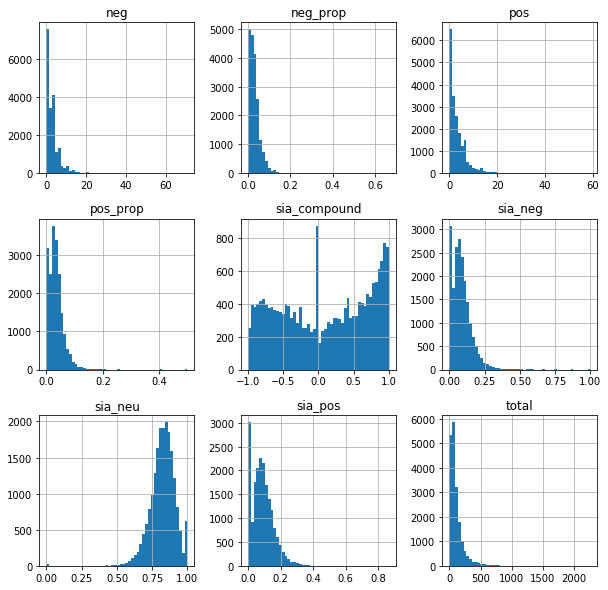

In [31]:
df[df.type == "low"].hist(bins = 50, figsize = (10,10));

#### Distribution of Sentiment Scores: High-Star Reviews

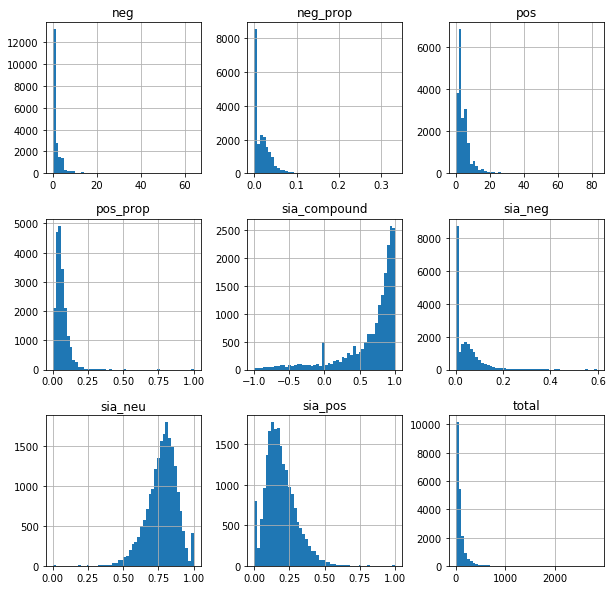

In [32]:
df[df.type =="high"].hist(bins = 50, figsize = (10,10));

Looking at the above graphics, the comparison between the high- and low- star reviews is a little difficult due to the differences in scales. However, we can definitely say that the low star reviews run the gamut from -1 to 1 on the `Sentiment Intensity Analyzer` "compound" score. 